# RPGRIP1 and Associated Syndrome


Variants in [RPGRIP1](https://omim.org/entry/605446) are associated with [cone-rod dystrophy-13 (CORD13)] and
[Leber congenital amaurosis 6](https://omim.org/entry/613826). Both conditions follow an autosomal recessive
mode of inheritance.

Data in this cohort are dervied from [Beryozkin A, et al. (2021) Retinal Degeneration Associated With RPGRIP1: A Review of Natural History, Mutation Spectrum, and Genotype-Phenotype Correlation in 228 Patients. Front Cell Dev Biol](https://pubmed.ncbi.nlm.nih.gov/34722527/)


<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) report:

> [Quote relevant finding from the study]

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

TODO -- find a more comprehensive collection of citations for [GeneName]. At the end of the introduction for a gene, we would write something like this:

> Example: Therefore, we tested missense vs other variants (inspection of the distribution of variants showed that the other variant categories in our dataset are [list other variant categories], all of which we deemed to be null variants for the purposes of this analysis). We also tested the two most common missense variants ([DETAILS]) for correlations.

In [21]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}.')
print(f"Using gpsea version {gpsea.__version__}.")

Loaded HPO v2024-08-13.
Using gpsea version 0.4.2.dev0.


In [22]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
cohort_name = "RPGRIP1"
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
print(f"Imported {len(phenopackets)} phenopackets from cohort {cohort_name}")

Imported 229 phenopackets from cohort RPGRIP1


In [24]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()  

Individuals Processed: 100%|██████████| 229/229 [00:39<00:00,  5.82individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
#

Validated under none policy
No errors or warnings were found


In [25]:
RPGRIP1_MANE_transcript = 'NM_020366.4'
RPGRIP1_protein_id = 'NP_065099.3' # X-linked retinitis pigmentosa GTPase regulator-interacting protein 1 isoform 1

RPGRIP1_MANE_transcript = 'NM_020366.4'
RPGRIP1_protein_id = 'NP_065099.3'

In [27]:
from gpsea.view import CohortViewable
cv = CohortViewable(hpo=hpo)
cv.process(cohort=cohort, transcript_id=RPGRIP1_MANE_transcript)

HPO Term,ID,Seen in n individuals
Very low visual acuity,HP:0032122,89
Eye poking,HP:0001483,28
Abnormal electroretinogram,HP:0000512,28
Moderately reduced visual acuity,HP:0030515,24
Moderate hypermetropia,HP:0031729,12
Global developmental delay,HP:0001263,12
Constriction of peripheral visual field,HP:0001133,10
High hypermetropia,HP:0008499,9
Severely reduced visual acuity,HP:0001141,6
High myopia,HP:0011003,4


In [28]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(RPGRIP1_MANE_transcript)
protein_meta = pms.annotate(RPGRIP1_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_84505/3621751448.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


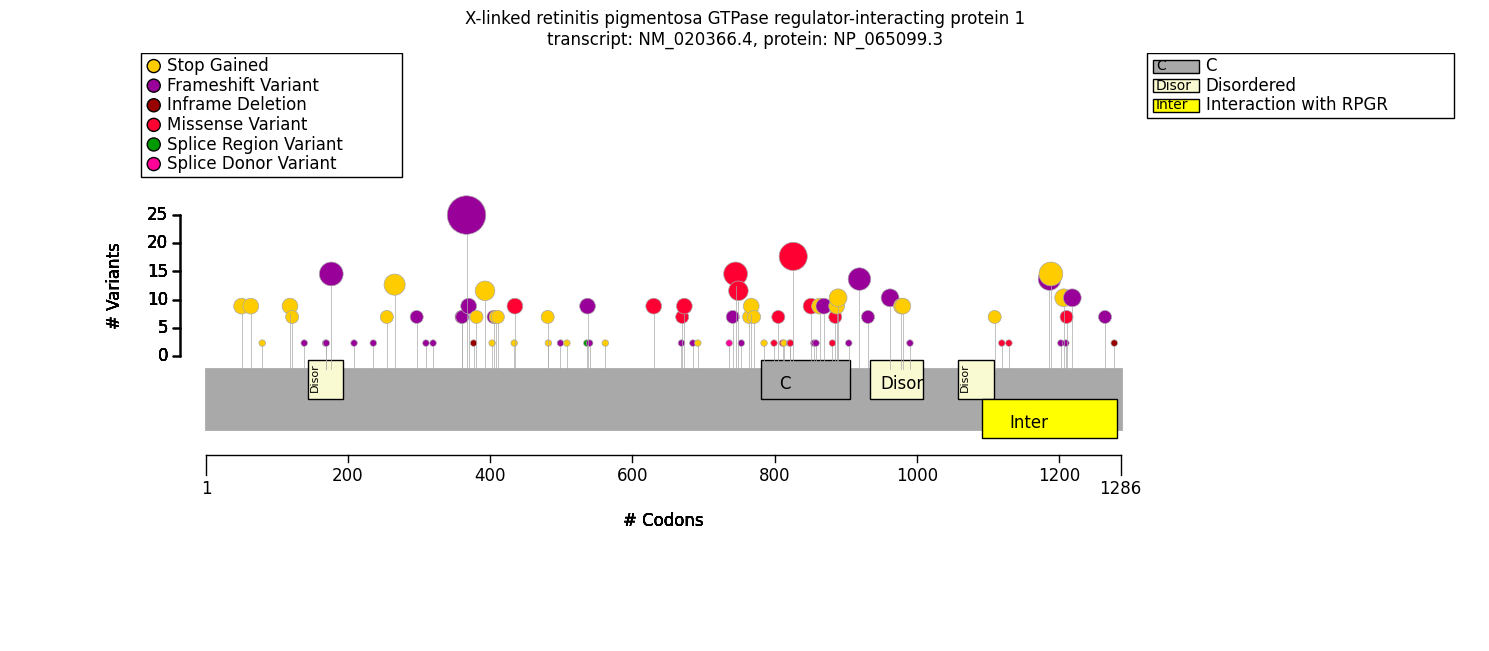

In [29]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [30]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_recessive,VariantPredicate

vp = VariantPredicates.variant_key("14_21312457_21312458_GA_G") 
gt_predicate = autosomal_recessive(
    variant_predicate=vp,
)

gt_predicate.display_question()

from gpsea.analysis.predicate.genotype import biallelic_predicate
gt_predicate = biallelic_predicate(
    a_predicate=vp,
    b_predicate=~vp,
    names=("A", "B"),
    partitions = ({0,}, {1, 2})
)


gt_predicate.display_question()


'Allele group: A/A, A/B OR B/B'

In [31]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.model import FeatureType
from gpsea.analysis.predicate import PatientCategories
from gpsea.view import MtcStatsViewer
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.mtc_filter import UseAllTermsMtcFilter
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.pcats import HpoTermAnalysis


pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)

mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.1)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

count_statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)




# missense_effects = (VariantEffect.MISSENSE_VARIANT)
# missense_predicate = VariantPredicates.all(VariantPredicates.variant_effect(eff) for eff in missense_effects)


result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF04,Skipping term because all genotypes have same HPO observed proportions,16
HMF05,Skipping term because one genotype had zero observations,5
HMF06,Skipping term with less than 7 observations (not powered for 2x2),5
HMF08,Skipping general term,10


In [32]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                               A/A         A/B OR B/B          \
                                         Count Percent      Count Percent   
Eye poking [HP:0001483]                  16/16    100%      12/23     52%   
Global developmental delay [HP:0001263]   4/25     16%      8/204      4%   

Allele group                                                          
                                        Corrected p values  p values  
Eye poking [HP:0001483]                           0.001838  0.000919  
Global developmental delay [HP:0001263]           0.030151  0.030151

In [37]:
is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=RPGRIP1_MANE_transcript)

gt_predicate = biallelic_predicate(
    a_predicate=is_frameshift,
    b_predicate=~is_frameshift,
    names=("A", "B"),
    partitions = ({0,}, {1, 2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


gt_predicate.display_question()
summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                               A/A         A/B OR B/B          \
                                         Count Percent      Count Percent   
Global developmental delay [HP:0001263]   8/68     12%      4/161      2%   
Eye poking [HP:0001483]                  21/25     84%       7/14     50%   
Abnormal electroretinogram [HP:0000512]  11/11    100%      17/18     94%   

Allele group                                                          
                                        Corrected p values  p values  
Global developmental delay [HP:0001263]           0.021949  0.007316  
Eye poking [HP:0001483]                           0.049585  0.033057  
Abnormal electroretinogram [HP:0000512]           1.000000  1.000000

In [38]:
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=RPGRIP1_MANE_transcript)

gt_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    names=("A", "B"),
    partitions = ({0,}, {1, 2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


gt_predicate.display_question()
summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                              A/A         A/B OR B/B          \
                                        Count Percent      Count Percent   
Eye poking [HP:0001483]                   2/4     50%      26/35     74%   
Abnormal electroretinogram [HP:0000512]   3/3    100%      25/26     96%   

Allele group                                                          
                                        Corrected p values  p values  
Eye poking [HP:0001483]                                1.0  0.561878  
Abnormal electroretinogram [HP:0000512]                1.0  1.000000

In [39]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Empty DataFrame
Columns: [(FEMALE, Count), (FEMALE, Percent), (MALE, Count), (MALE, Percent), (, p values)]
Index: []